# Notes on preprocessing WAV files for later neural net analysis:  Val Veirs, Nov. 17, 2018
    This Jupyter Notebook contains some Python routines that can read WAV files and transform them into spectrograms.

To run these scripts, Python3 must be installed and the following libraries must load:

In [6]:
import numpy as np
import wavio
from scipy.fftpack import fft, ifft
from scipy.signal import  hann
import matplotlib.pyplot as plt
import cv2

I used a combination of conda and pip and pip3 to install the needed packages.  I don't really understand this at all.  Two examples --
   pip install wavio
     https://github.com/WarrenWeckesser/wavio
   conda install -c conda-forge opencv  

In [ ]:
The flow here goes something like:
    read wav file into numpy array called wav
    normalize wav to -3dB (half-full scale -1 -> 1)
    calculate Fourier power spectrum and save in array specGram
       each row is a successive time step
       each column is a successive frequency (~170 - ~10,000 hz)
   normalize power spectrum to 1
   plot power spectrum array
       note that time runs from the top down and frequency from left to right
   convert power spectrum array to binary array
       a value is 1 only if greater that 3 std dev greater than its row (freq) and column (time)    
   save binary array file
   

In [7]:
import os
cwd = os.getcwd()  #  current working directory
wavFile = cwd+"/"+"FordOsborneLabeled/S_19.wav"

wav = wavio.read(wavFile)
print(wav.rate)
Nwav = wav.data.shape[0]  #number of datapoints in wav file

44100


In [3]:
#normalize amplitude of wav
wavMax = np.amax(wav.data)
wav.data = wav.data/(wavMax*2.0)  # normalize to -3 dB amplitude

In [4]:
#prepare for FFT calculations
fftSize = 2048
overlap = 75  # percent overlap of FFT windows

h = hann(fftSize)  # Hanning window
x = np.zeros([fftSize])
jump = int(fftSize*(100-overlap)/overlap)  # here we decide how far to jump forward for each successive block of data
jumpPtr = 0
jumpMax = int(Nwav//jump) # this is number of fft blocks in this WAV file
specGram = np.zeros([jumpMax, fftSize//2-4])

In [5]:
# loop through the wav file building specGram array - 
      # each row is a time slice and each column is the spectral power at successive frequencies
wavPtr = 0
while (wavPtr < Nwav-fftSize):
    for i in range(fftSize):
        x[i] = wav.data[i+wavPtr]
    yhf = fft(x*h)    
    pwr = np.absolute(yhf)
    pwr[0] = 0  # drop any DC term
    pwrMax = np.amax(pwr)
#    pwr = np.log10(pwr/pwrMax)
    pwr /= pwrMax
    for i in range(fftSize//4 - 4):       # select max of range to limit frequency to less than ~10 kHz
        specGram[jumpPtr, i] = pwr[i+4]   # transfer pwr >~ 170 hz and pwr <~ 10khz
    freq = np.linspace(1.0,wav.rate/2.0,fftSize//2)
#    plt.plot(np.log10(freq[2:]),pwr[2:fftSize//2])
#    plt.plot(freq[2:],pwr[2:fftSize//2])
#    plt.grid()
#    plt.show()

    wavPtr += jump
    jumpPtr += 1
#    print(wavPtr)
    
#print(specGram)    
print(specGram.shape)

(46, 1020)


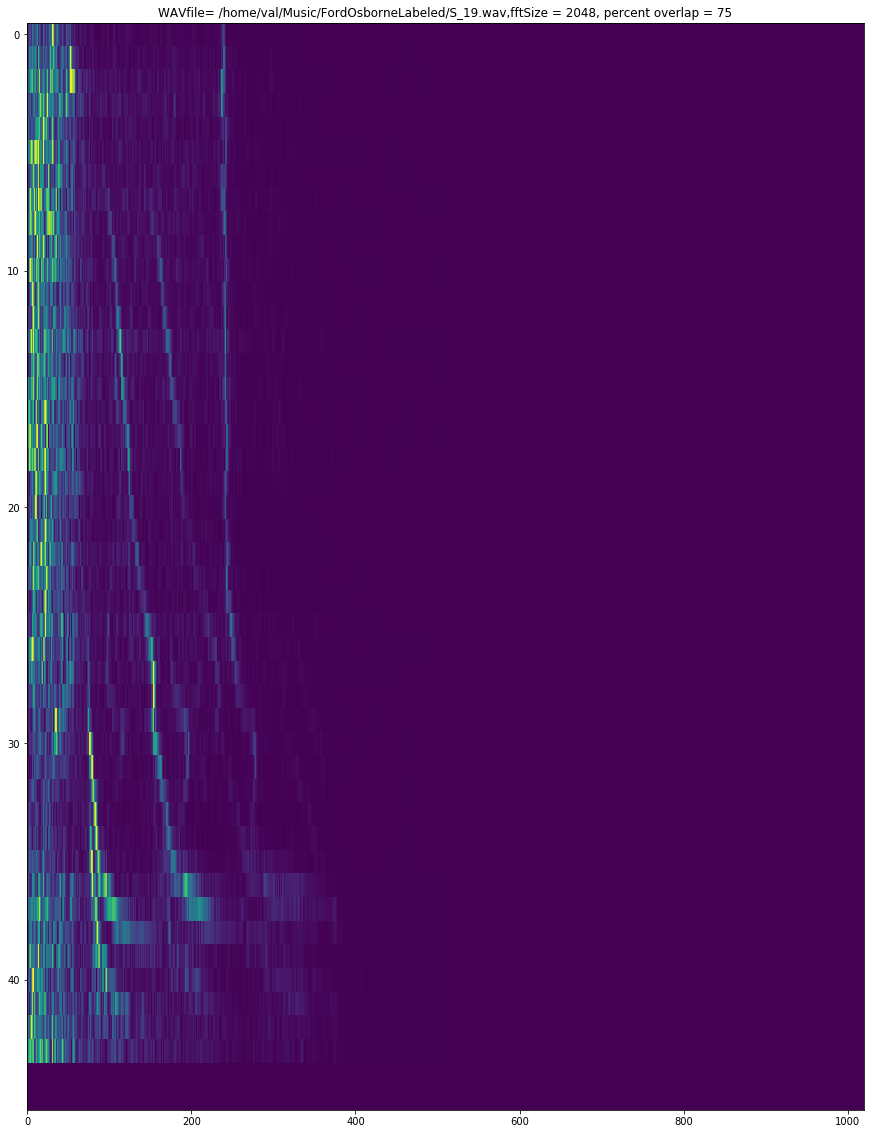

In [7]:
# these lines will make a plot of the specGram array
fig, ax = plt.subplots(figsize=(15,20))
ax.imshow(specGram, interpolation='nearest')
ax.set_aspect('auto')
plt.title("WAVfile= %s,fftSize = %d, percent overlap = %d" % (wavFile,fftSize,overlap))
plt.show()

It may be interesting to create 1's & 0's binary thresholded arrays.  Here is one way to do it.

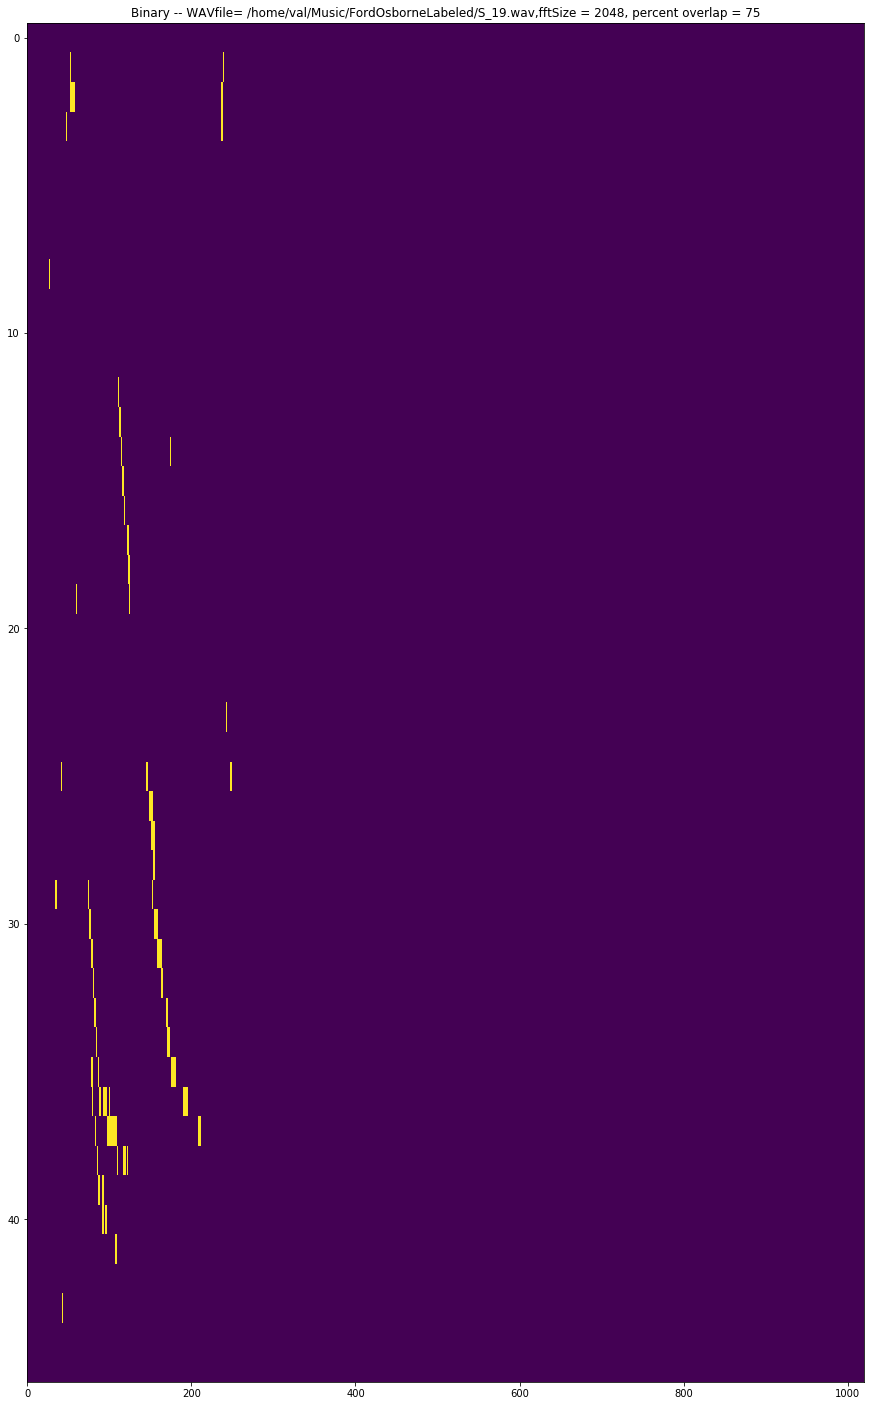

In [8]:
# convert to binary
#   pixel = 0 unless gtr than 3 times median in freq and time directions

specBinary = np.zeros([jumpMax, fftSize//2-4], dtype='bool')
    
for i in range(specBinary.shape[0]): ## frequency direction
    for j in range(specBinary.shape[1]): ## time direction
       if (specGram[i,j] > np.mean(specGram[i,:]) + 3*np.std(specGram[i,:])) & (specGram[i,j] > np.mean(specGram[:,j]) + 3*np.std(specGram[:,j]) ):
           specBinary[i,j] = 1
           
fig, ax = plt.subplots(figsize=(15,25))
ax.imshow(specBinary, interpolation='nearest')
ax.set_aspect('auto')
plt.title("Binary -- WAVfile= %s,fftSize = %d, percent overlap = %d" % (wavFile,fftSize,overlap))
plt.show()

Saving file /home/val/NN/WAVprocessor/processedFiles/binary_S_19
Saving file /home/val/NN/WAVprocessor/processedFiles/specGramS_19


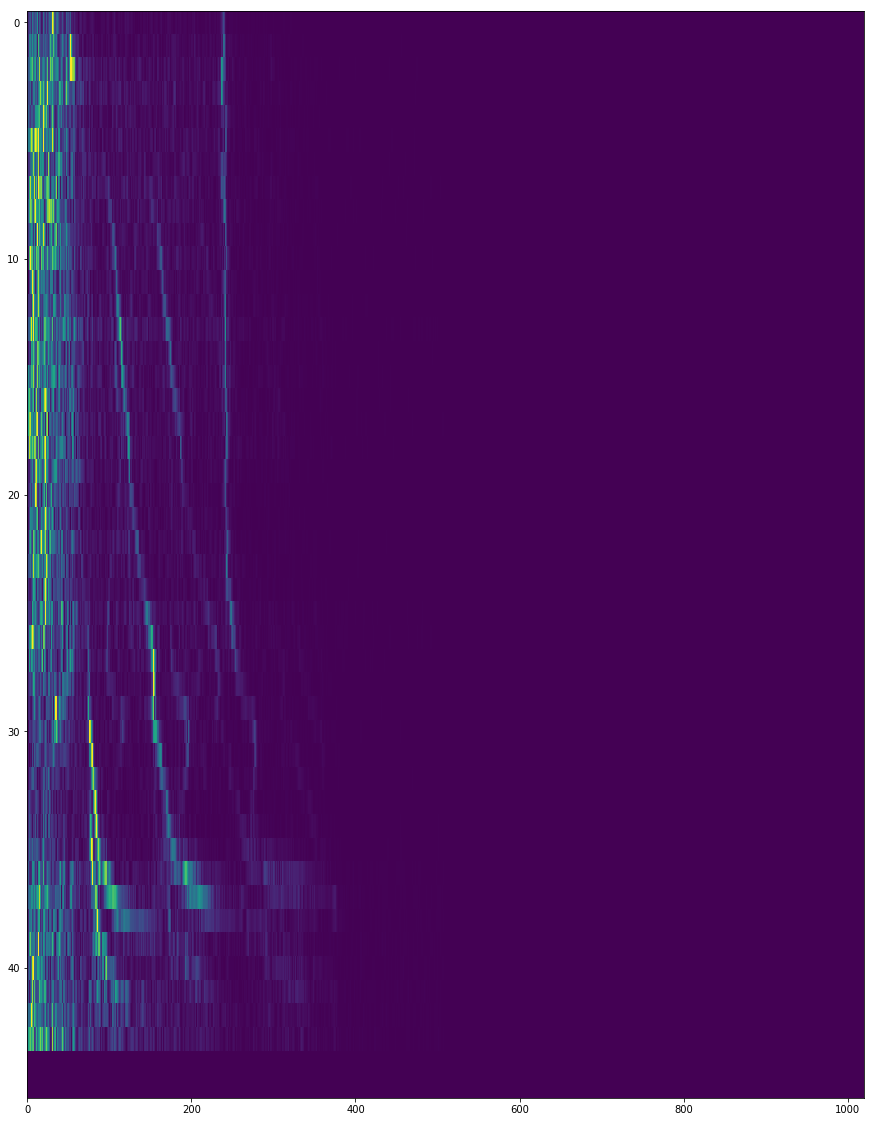

In [9]:
#saving these numpy arrays is easy as is reading them - creat destination folder and pay attention to path!
outFile = cwd + "/processedFiles/binary_"+wavFile.split(sep='/')[-1].split(sep='.')[0]
print("Saving file %s" % outFile)
np.save(outFile,specBinary)

outFile = cwd + "/processedFiles/specGram_"+wavFile.split(sep='/')[-1].split(sep='.')[0]
print("Saving file %s" % outFile)
np.save(outFile,specGram)

# here is a load:
imgNp = np.load(cwd + '/processedFiles/specGram_S_19.npy') 
#take a look
fig, ax = plt.subplots(figsize=(15,20))
ax.imshow(imgNp, interpolation='nearest')
ax.set_aspect('auto')
plt.show()

Here we apply some openCV image processing methods
    dilation adds pixels near existing pixels to connect up nearby regions
    erosion subtracts pixels along edges making lines thinner for example
    these tranforms can be iterated multiple times and linked one after another etc.
Below are a few examples:    

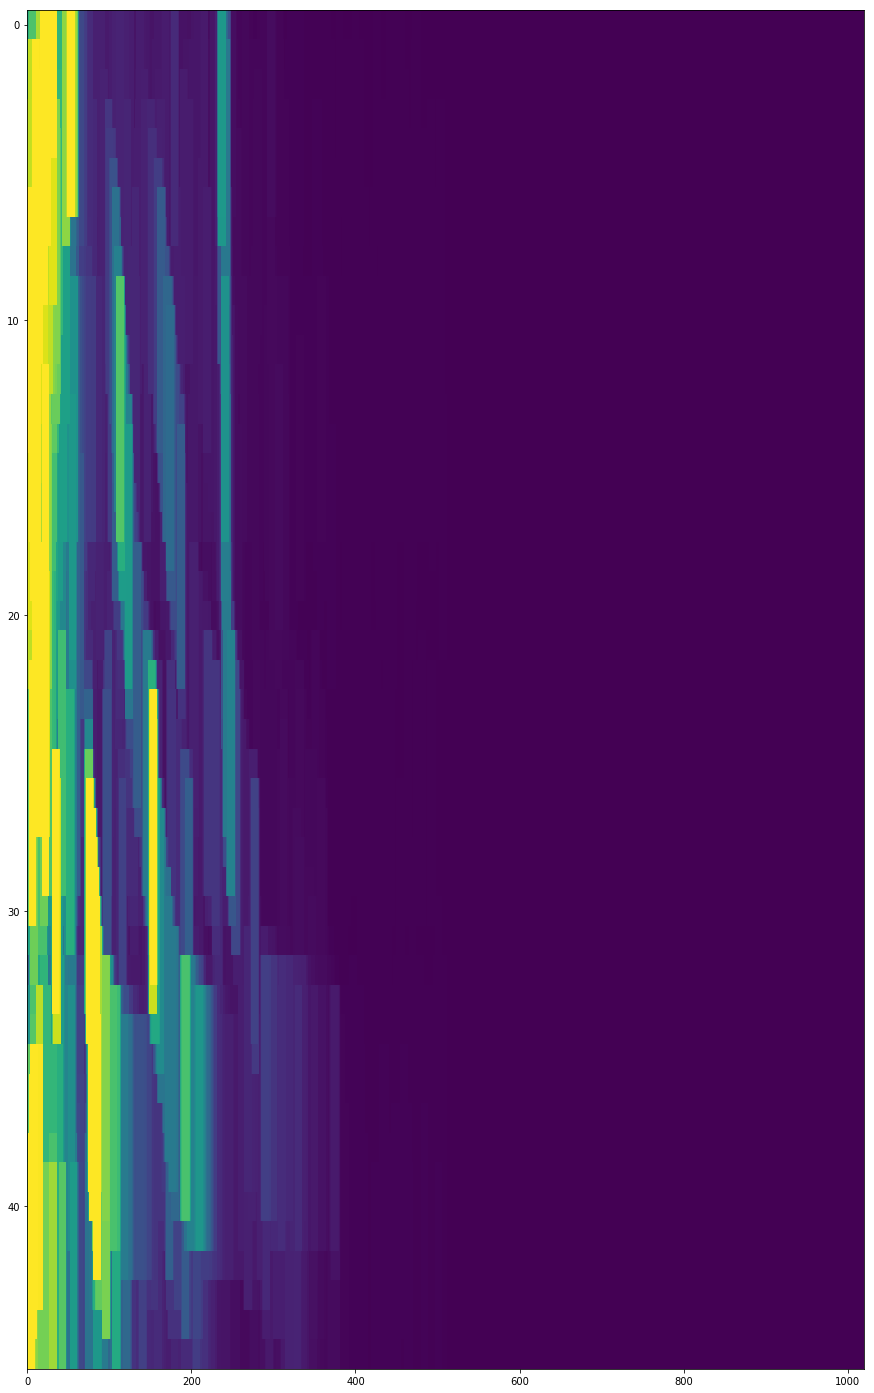

In [10]:
# The kernel is convolved with each point in the array
# The iterations parameter controls how many successive dilations or erosions you wish to apply
kernel = np.ones((5,5), np.uint8) 

img_dilation = cv2.dilate(imgNp, kernel, iterations=2) 

#plot the result
fig, ax = plt.subplots(figsize=(15,25))
ax.imshow(img_dilation, interpolation='nearest')
ax.set_aspect('auto')
plt.show()

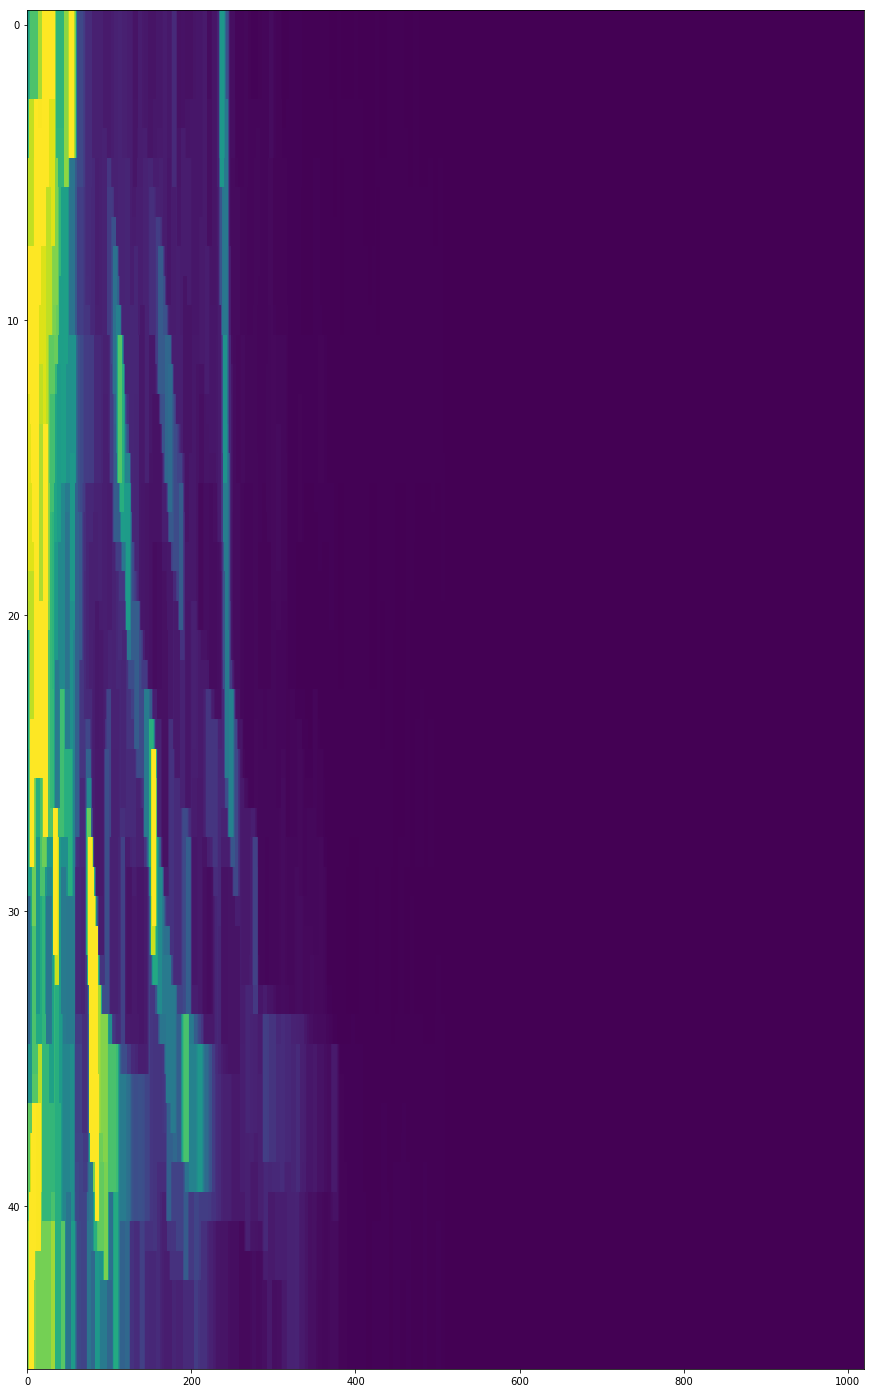

In [11]:
img_erosion = cv2.erode(img_dilation, kernel, iterations=1)  # now, go back the other way and erode the image

fig, ax = plt.subplots(figsize=(15,25))
ax.imshow(img_erosion, interpolation='nearest')
ax.set_aspect('auto')
plt.show()

In [12]:
# save this transformed spectrogram  e_d2 signifies 1 erosion after 2 dilations
outFile = "/home/val/NN/WAVprocessor/processedFiles/e_d2_"+wavFile.split(sep='/')[-1].split(sep='.')[0]
print("Saving file %s" % outFile)
np.save(outFile,img_erosion)

Saving file /home/val/NN/WAVprocessor/processedFiles/e_d2_S_19


Below is a routine that can make the binary image with the image file and the thresholding parameter passed into the function


In [16]:
# convert to binary
#   pixel = 0 unless gtr than Nsd standard deviations above the mean in both frequency and time

def makeBinary(img, Nsd):
    specBinary = np.zeros([img.shape[0], img.shape[1]], dtype='bool')      
    for i in range(specBinary.shape[0]): ## frequency direction
        for j in range(specBinary.shape[1]): ## time direction
           if (img[i,j] > np.mean(img[i,:]) + Nsd*np.std(img[i,:])) & (img[i,j] > np.mean(img[:,j]) + Nsd*np.std(img[:,j]) ):
               specBinary[i,j] = 1
    print(specBinary.shape)
    return specBinary

(46, 1020)


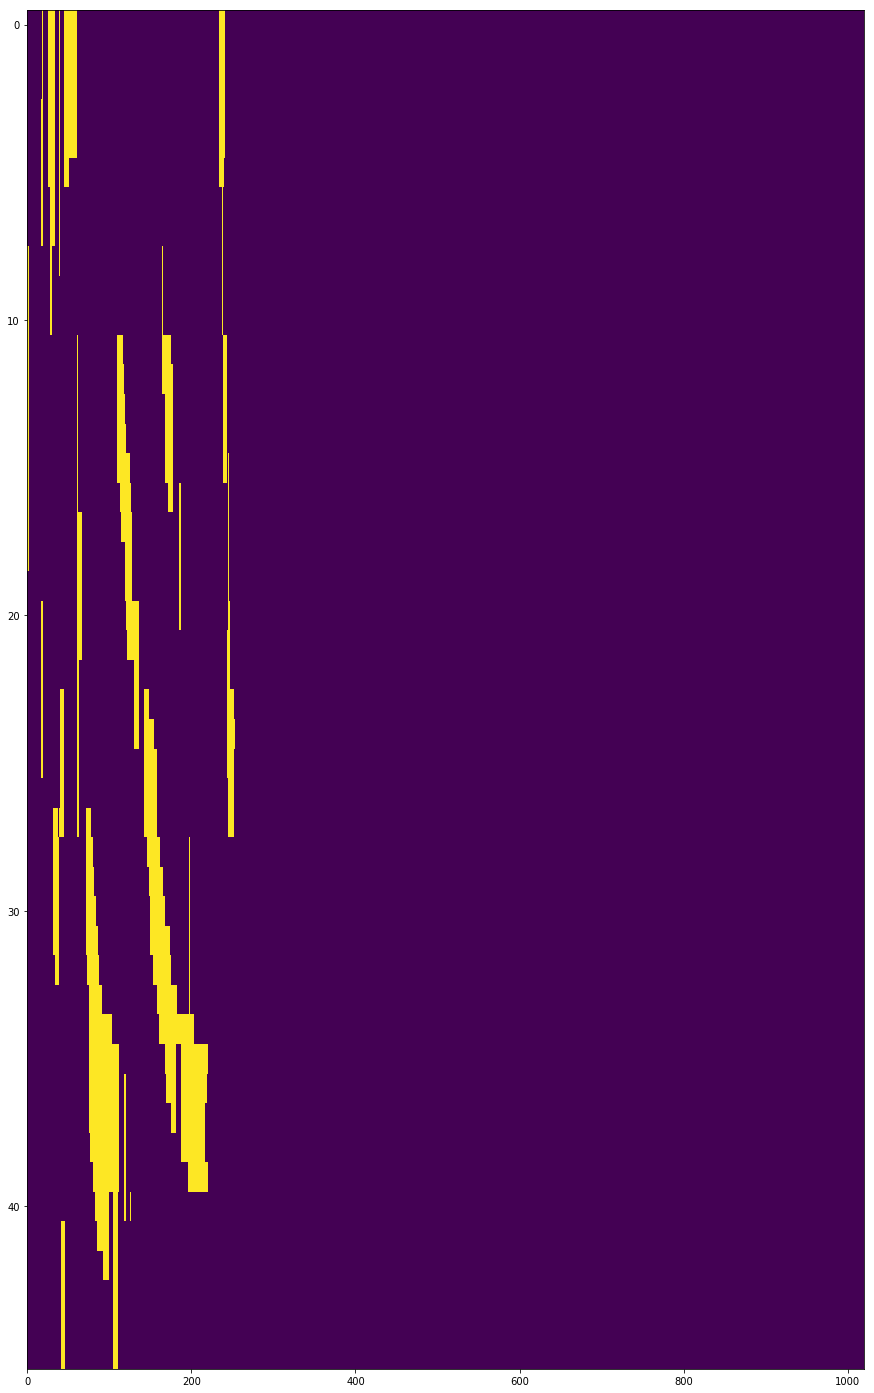

Saving file /home/val/NN/WAVprocessor/processedFiles/binary_e_d2_S_19


In [15]:
specBinary = makeBinary(img_erosion,1) 
# plot and save the result
fig, ax = plt.subplots(figsize=(15,25))
ax.imshow(specBinary, interpolation='nearest')
ax.set_aspect('auto')
plt.show()

outFile = cwd + "/processedFiles/binary_e_d2_"+wavFile.split(sep='/')[-1].split(sep='.')[0]
print("Saving file %s" % outFile)
np.save(outFile,specBinary)

'/home/val/NN/WAVprocessor'